# Física Nuclear y de Partículas #

## Tema 2. La interacción nuclear.  ##


César Fernández Ramírez\
Departamento de Física Interdisciplinar\
Universidad Nacional de Eduación a Distancia

Versión: Junio 2024

Contenidos:

- Propiedades físicas del deuterón



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import fsolve
from scipy.integrate import quad

jpac_blue   = "#1F77B4"; jpac_red    = "#D61D28";
jpac_green  = "#2CA02C"; jpac_orange = "#FF7F0E";
jpac_purple = "#9467BD"; jpac_brown  = "#8C564B";
jpac_pink   = "#E377C2"; jpac_gold   = "#BCBD22";
jpac_aqua   = "#17BECF"; jpac_grey   = "#7F7F7F";

jpac_color = [jpac_blue, jpac_red, jpac_green, 
              jpac_orange, jpac_purple, jpac_brown,
              jpac_pink, jpac_gold, jpac_aqua, jpac_grey, 'black' ];

jpac_axes = jpac_color[10]
dashes = 60*'-'

# the service URL
livechart = "https://nds.iaea.org/relnsd/v1/data?"

# There have been cases in which the service returns an HTTP Error 403: Forbidden
# use this workaround
import urllib.request
def lc_pd_dataframe(url):
    req = urllib.request.Request(url)
    req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
    return pd.read_csv(urllib.request.urlopen(req))

df = lc_pd_dataframe(livechart + "fields=ground_states&nuclides=all")
df = df[pd.to_numeric(df['binding'],errors='coerce').notna()]
df['binding'] /= 1000
df['A'] = df['n']+df['z']

uma = 931.4941024/1000000/1000
mproton, mneutron = 938.27208943, 939.56542052
fmtomev = 197.32

def yukawa(k,la,r):
    return -k*np.exp(-r/la)/r
def yukawaeff(k,la,l,m,r):
    return yukawa(k,la,r) + l*(l+1)/(2*m*r**2)


Propiedades físicas del deuterón

In [2]:
deuteron = df.loc[ ((df['z']==1) & (df['n']==1))] 
print(dashes+dashes)
print('Propiedades del deuterón:')
print(dashes+dashes)
print('A=',deuteron['A'].values[0],';','Z=',deuteron['z'].values[0],'(',deuteron['symbol'].values[0],');','N=',deuteron['n'].values[0])
print('Año de descubrimiento: ', int(deuteron['discovery'].values[0]))
print('Vida media: ', deuteron['half_life'].values[0])
print('Abundancia: ', deuteron['abundance'].values[0],'%')
print('Radio de carga: ', deuteron['radius'].values[0],'+/-',deuteron['unc_r'].values[0],'fm')
print('Energía de ligadura: ', deuteron['binding'].values[0]*deuteron['A'].values[0],'+/-',deuteron['unc_ba'].values[0]*deuteron['A'].values[0],'MeV')
print('Masa: ', deuteron['atomic_mass'].values[0]/1000,'+/-',deuteron['unc_am'].values[0]/1000,'u.m.a.',';',deuteron['atomic_mass'].values[0]*uma,'GeV')
print('Dipolo magnético: ', deuteron['magnetic_dipole'].values[0],'+/-',deuteron['unc_md'].values[0],'magnetones de Bohr')
print('Cuadrupolo eléctrico: ', deuteron['electric_quadrupole'].values[0]*1000,'+/-',deuteron['unc_eq'].values[0]*1000,'mb')
print('Energía de separación del protón:  ', deuteron['sp'].values[0]/1000,'+/-',deuteron['unc_sp'].values[0]/1000,'MeV')
print('Energía de separación del neutrón: ', deuteron['sn'].values[0]/1000,'+/-',deuteron['unc_sn'].values[0]/1000,'MeV')
print(dashes+dashes)


------------------------------------------------------------------------------------------------------------------------
Propiedades del deuterón:
------------------------------------------------------------------------------------------------------------------------
A= 2 ; Z= 1 ( H ); N= 1
Año de descubrimiento:  1932
Vida media:  STABLE
Abundancia:  0.0145 %
Radio de carga:  2.1421 +/- 0.0088 fm
Energía de ligadura:  2.2245662000000004 +/- 0.0004 MeV
Masa:  2014.1017778439998 +/- 1.5000000000000002e-08 u.m.a. ; 1.8761239276950408 GeV
Dipolo magnético:  0.857438231 +/- 5e-09 magnetones de Bohr
Cuadrupolo eléctrico:  2.8578 +/- 0.0003 mb
Energía de separación del protón:   2.2245662000000004 +/- 4.0000000000000003e-07 MeV
Energía de separación del neutrón:  2.2245662000000004 +/- 4.0000000000000003e-07 MeV
------------------------------------------------------------------------------------------------------------------------


Función de onda del deuterón (hipótesis de esfericidad y potencial cuadrado)

Para R0= 2.1421 , V0= 32.65081700860736 MeV
R0*R0*V0= 149.82129110599465 MeV fm2
<r>= 0.00028698495535569516 fm


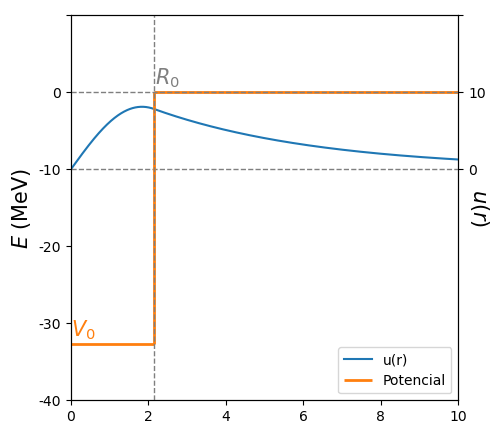

In [3]:
def k1(mu,Ed,V0):
    return np.sqrt(2*mu*(V0+Ed))
def k2(mu,Ed):
    return np.sqrt(-2*mu*Ed)

def fdowell(r0,mu,V0,Eb,r):
    Ed = - Eb
    if (r<=r0):
        return np.sin(k1(mu,Ed,V0)*r)/np.sin(k1(mu,Ed,V0)*r0)
    else:
        return np.exp(k2(mu,Ed)*r0)*np.exp(-k2(mu,Ed)*r)

def continuity(R0,Eb,mu):
    Ed = - Eb
    func = lambda V0: k2(mu,Ed)/k1(mu,Ed,V0) + 1./np.tan(k1(mu,Ed,V0)*R0)
    initial_guess = 30
    return fsolve(func, initial_guess)

def integrand(r,r0,mu,V0,Eb):
    return np.abs(fdowell(r0,mu,V0,Eb,r))**2

def integrandr(r,r0,mu,V0,Eb):
    return r*np.abs(fdowell(r0,mu,V0,Eb,r))**2/fmtomev


mu = mproton*mneutron/(mproton+mneutron)
Ed = deuteron['binding'].values[0]*deuteron['A'].values[0]
R0 = deuteron['radius'].values[0]
V0 = continuity(R0/fmtomev,Ed,mu)[0]
print('Para R0=',R0,', V0=',V0,'MeV')
print('R0*R0*V0=',R0*R0*V0,'MeV fm2')


r = np.linspace(0,10,1000)
I = quad(integrand, 0, 100,args=(1.96/fmtomev,mu,V0,Ed))
ur = np.array([ fdowell(R0/fmtomev,mu,V0,Ed,r[i]/fmtomev)/np.sqrt(I[0]) for i in np.arange(len(r))])

IR = quad(integrandr, 0, 100,args=(R0/fmtomev,mu,V0,Ed))
print('<r>=',IR[0]*fmtomev,'fm')

fig, ax1 = plt.subplots(figsize=(5,5))
ax2 = ax1.twinx()
ax1.set_ylabel(r'$E$ (MeV)',fontsize=15)
plt.xlabel(r'$r$ (fm)',fontsize=15)
plt.xlim((0.,10.))
plt.ylim((-40,10.))
ax1.set_yticks([10,0,-10,-20,-30,-40],[' ','0','-10','-20','-30','-40'])

ax2.set_yticks([10,0,-10],[' ','10','0'])
ax2.set_ylabel(r'$u(r)$',fontsize=15, rotation=-90)

plt.plot(r,ur-10,'-',c=jpac_color[0],label='u(r)')
plt.hlines(0,R0,10,colors=jpac_color[3],  lw=2., linestyles='solid',label='Potencial')
plt.hlines(-10,0,10,colors=jpac_color[9],  lw=1., linestyles='dashed')

plt.hlines(-V0,0,R0,colors=jpac_color[3], lw=2., linestyles='solid')
plt.vlines(R0,-V0,0,colors=jpac_color[3], lw=2., linestyles='solid')
plt.vlines(R0,-40,10,colors=jpac_color[9], lw=1., linestyles='dashed')
plt.hlines(0,0,10,colors=jpac_color[9], lw=1., linestyles='dashed')
plt.text(0,-V0+1,r'$V_0$',c=jpac_color[3],fontsize=15)
plt.text(R0+0.02,1,r'$R_0$',c=jpac_color[9],fontsize=15)
plt.legend(loc='lower right',ncol=1,frameon=True)
plt.show()    
#fig.savefig("deuteronfdo.pdf", bbox_inches='tight')
